<a href="https://colab.research.google.com/github/osmaanural/KidneyClassification/blob/main/KIDNEYCLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.utils as vutils
import cv2


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import os
import shutil
import random

# Orijinal veri setinin olduğu ana klasör
dataset_dir = "/content/drive/Othercomputers/Dizüstü Bilgisayarım/Masaüstü/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"   # senin 4 klasörün burada olacak
# Çıkış klasörleri
output_train = "/content/drive/Othercomputers/Dizüstü Bilgisayarım/Masaüstü/trainkidney"
output_test = "/content/drive/Othercomputers/Dizüstü Bilgisayarım/Masaüstü/testkidney"

# Train ve test klasörlerini oluştur
for folder in [output_train, output_test]:
    os.makedirs(folder, exist_ok=True)

# Tüm sınıf klasörlerini al
classes = os.listdir(dataset_dir)

for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    if not os.path.isdir(class_dir):
        continue

    images = os.listdir(class_dir)
    random.shuffle(images)

    # %80 eğitim, %20 test
    split_idx = int(len(images) * 0.8)
    train_files = images[:split_idx]
    test_files = images[split_idx:]

    # Train klasörüne taşı
    train_class_dir = os.path.join(output_train, cls)
    os.makedirs(train_class_dir, exist_ok=True)
    for img in train_files:
        shutil.move(os.path.join(class_dir, img), os.path.join(train_class_dir, img))

    # Test klasörüne taşı
    test_class_dir = os.path.join(output_test, cls)
    os.makedirs(test_class_dir, exist_ok=True)
    for img in test_files:
        shutil.move(os.path.join(class_dir, img), os.path.join(test_class_dir, img))

print("✅ Veri seti %80 train / %20 test olarak ayrıldı ve taşındı.")


✅ Veri seti %80 train / %20 test olarak ayrıldı ve taşındı.


In [2]:
def data_loader(batch_size=32):
  transform=transforms.Compose([
      transforms.Grayscale(num_output_channels=1), ##tek kanallı görüntü
      transforms.Resize((256,256)),
      transforms.ToTensor(),

      transforms.Normalize((0.5),(0.5))
  ])

  train_datasets=datasets.ImageFolder(root="/content/drive/Othercomputers/Dizüstü Bilgisayarım/Masaüstü/trainkidney",transform=transform )
  test_datasets=datasets.ImageFolder(root="/content/drive/Othercomputers/Dizüstü Bilgisayarım/Masaüstü/testkidney",transform=transform)


  train_loader=DataLoader(train_datasets,batch_size=batch_size,shuffle=True)
  test_loader=DataLoader(test_datasets,batch_size=batch_size,shuffle=False)

  return train_loader,test_loader


train_loader,test_loader=data_loader()

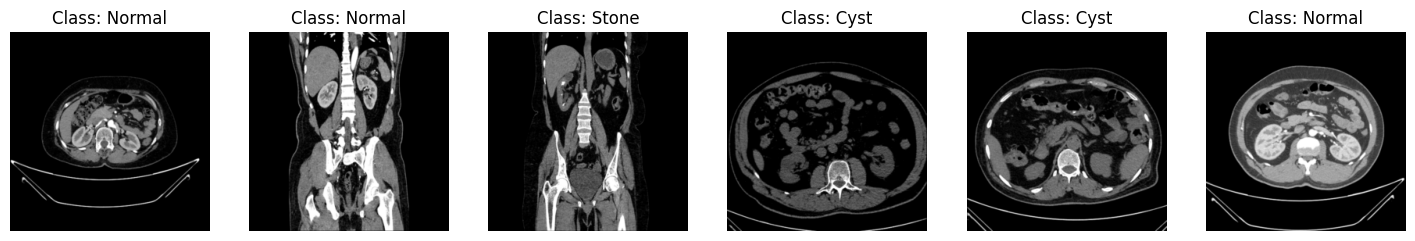

In [25]:
# 1. Görüntü gösterme fonksiyonu
def imshow(img):
    img = img / 2 + 0.5  # normalize düzeltmesi ([-1,1] -> [0,1])
    np_img = img.numpy()
    plt.imshow(np_img.squeeze(0), cmap="gray")

# 3. Train loader'dan bir batch çekme
def get_sample_images(train_loader):
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    return images, labels

# 4. Görselleştirme fonksiyonu
def visualize(n=6):
    # Burada train_dataset'i de alıyoruz
    train_loader, test_loader = data_loader()
    train_dataset = train_loader.dataset  # ImageFolder dataset

    images, labels = get_sample_images(train_loader)

    plt.figure(figsize=(n * 3, 3))  # Görsel boyutu: n*3 genişlik
    for i in range(n):
        plt.subplot(1, n, i + 1)
        imshow(images[i])
        # label'i klasör adı ile göster
        class_name = train_dataset.classes[labels[i].item()]
        plt.title(f"Class: {class_name}")
        plt.axis("off")
    plt.show()


visualize()


# Model

In [3]:
## Modelin Oluşturulması

class CNN(nn.Module):

  def __init__(self):
    super(CNN,self).__init__()
    self.conv1=nn.Conv2d(1,16,3,padding=1)   #256--> 128
    self.relu=nn.ReLU()
    self.pool=nn.MaxPool2d(2,2)
    self.conv2=nn.Conv2d(16,32,3,padding=1)   # 128--> 64
    self.conv3=nn.Conv2d(32,64,3,padding=1)   # 64--> 32
    # self.conv4=nn.Conv2d(64,128,3,padding=1)  # 32--> 16
    self.bn1=nn.BatchNorm2d(16)
    self.dropout=nn.Dropout(0.25)
    self.fc1=nn.Linear(64*32*32,128)
    self.fc2=nn.Linear(128,4)

  def forward(self,x):
    x=self.conv1(x)  ## 16,256,256
    x=self.relu(x)
    x=self.pool(x)   ## 256--> 128
    x=self.bn1(x)
    # x=self.dropout(x)

    x=self.conv2(x)  ## 32,128,128
    x=self.relu(x)
    x=self.pool(x)   ## 128--> 64

    # x=self.dropout(x)

    x=self.conv3(x)  ## 64,64,64
    x=self.relu(x)
    x=self.pool(x)   ## 64 --> 32

    x=self.dropout(x)

    # x=self.conv4(x)  ## 128,32,32
    # x=self.relu(x)
    # x=self.pool(x)   ## 32--> 16
    # # x=self.dropout(x)

    x=x.view((x.size(0)),-1) ##düzleştirmek için 128,16,16  vekötr haline getirildi.
    x=self.fc1(x)
    x=self.relu(x)
    x=self.fc2(x)

    return x




In [4]:
## Call Back Tanımlanması
class EarlyStopping:
  def __init__(self,patience=5,min_delta=0.00001):
    self.patience=patience
    self.min_delta=min_delta
    self.counter=0
    self.best_loss=None

  def __call__(self,loss):
    if self.best_loss is None or loss>self.best_loss-self.min_delta:
      self.best_loss=loss
      self.counter=0
    else:
      self.counter+=1
    if self.counter>=self.patience:
      return True
    return False



In [5]:
## Model Eğitimi
epochs=100
lr=0.0001
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
model=CNN()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=lr)
early_stopping=EarlyStopping(patience=3,min_delta=0.00001)

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def training(model, train_loader, optimizer, criterion, epochs,early_stopping, device):
    model = model.to(device)
    train_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        all_preds = []
        all_labels = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Sınıf tahminlerini al
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Metrikleri hesapla
        acc = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.6f} | Acc: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

        if early_stopping(avg_loss):
            print(f"⏹️ Early stopping activated at epoch {epoch+1}")
            break

    # Loss grafiği
    plt.figure()
    plt.plot(range(1, len(train_losses)+1), train_losses, linestyle="--", label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Model Loss")
    plt.legend()
    plt.show()


Epoch 1/50 | Loss: 0.232184 | Acc: 0.9218 | Precision: 0.9283 | Recall: 0.8790 | F1: 0.8989
Epoch 2/50 | Loss: 0.011996 | Acc: 0.9983 | Precision: 0.9979 | Recall: 0.9973 | F1: 0.9976
Epoch 3/50 | Loss: 0.038646 | Acc: 0.9904 | Precision: 0.9897 | Recall: 0.9891 | F1: 0.9894
Epoch 4/50 | Loss: 0.004692 | Acc: 0.9995 | Precision: 0.9996 | Recall: 0.9991 | F1: 0.9994
⏹️ Early stopping activated at epoch 4


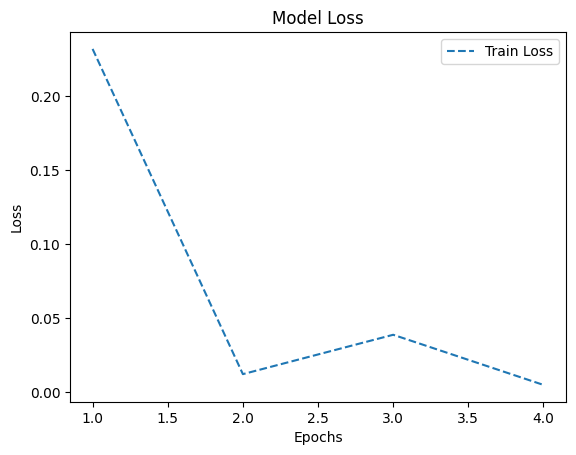

In [9]:
 training(model,train_loader,optimizer,criterion,epochs=50,early_stopping=early_stopping,device=device)

In [12]:
torch.save(model,"modelkindey.pt")

Test Accuracy: 100.00%
Precision: 1.00
Recall:    1.00
F1 Score:  1.00


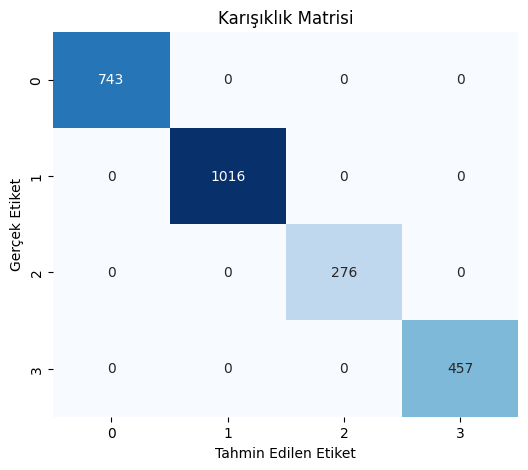

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
model.to(device)
model.eval()
correct = 0
total = 0
all_pred = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_pred.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 🔢 Doğruluk ve diğer metrikler
print(f"Test Accuracy: {100 * correct / total:.2f}%")

precision = precision_score(all_labels, all_pred, average="macro", zero_division=0)
recall = recall_score(all_labels, all_pred, average="macro", zero_division=0)
f1 = f1_score(all_labels, all_pred, average="macro", zero_division=0)

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

# 📊 Karışıklık Matrisi (Confusion Matrix)
cm = confusion_matrix(all_labels, all_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.title("Karışıklık Matrisi")
plt.show()
